In [33]:

import pandas as pd
import random
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler








df=pd.read_csv("generated_bank_data.csv")
num_customers=len(df)
df.head()
df.columns

Index(['Unnamed: 0', 'customer id', 'age', 'age group', 'gender',
       'income/month', 'account balance', 'loyalty score', 'education level',
       'products owned', 'type of campaign(s)',
       'duration of campaign(s) (days)', 'total ad spend',
       'product type advertised', 'prev campaign success', 'product cost',
       'has customer bought product', 'fb impressions', 'fb clicks',
       'insta impressions', 'insta clicks', 'tw impressions', 'tw clicks',
       'total clicks', 'total impressions', 'CTR', 'uses internet banking',
       'has_loan', 'total_withdrawals', 'total_deposits', 'transaction_count',
       'Facebook', 'Twitter', 'Instagram', 'Email'],
      dtype='object')

In [24]:
avg_transact_amt = 200
avg_transact_freq=10
df["total_withdrawals"] =  round((df["income/month"] * avg_transact_amt)  * ((1-df["age"])* avg_transact_freq),2) + np.random.normal(0, 100,size=num_customers)
df["total_deposits"] =  round((df["income/month"] * avg_transact_amt)  * ((1-df["age"])* avg_transact_freq),2) + np.random.normal(0, 100,num_customers)

df["total_withdrawals"]= df["total_withdrawals"].apply(lambda x:max(x,0))
df["total_deposits"]=df["total_deposits"].apply(lambda x:max(x,0))

def transaction_count(row):
    if row["total_withdrawals"]==0 and row["total_deposits"]==0:
        row["transaction_count"]=0
    else:
        row["transaction_count"] = int(round(10 * row["age"], 0))
    return row
df=df.apply(transaction_count,axis=1)


df["Facebook"]=df["fb clicks"].apply(lambda x:min(1,x))
df["Twitter"]=df["tw clicks"].apply(lambda x:min(1,x))
df["Instagram"]=df["insta clicks"].apply(lambda x:min(1,x))
df["Email"]=np.random.choice([0,1],size=num_customers)

df.rename(columns={"has housing loan":"has_loan"}, inplace=True)



# features used for clustering purpopses
cluster_features=["age","gender","income/month","account balance","loyalty score","education level","total_withdrawals"
          , "total_deposits","transaction_count", 'Facebook', 'Twitter', 'Email',
    'Instagram',"has_loan"]


df_cluster = df[cluster_features].dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)
X_scaled


array([[-1.06356076, -1.0034058 , -0.75032923, ..., -1.00020002,
         0.38175628, -0.52140205],
       [ 1.05688841,  0.99660576,  1.02764454, ...,  0.99980002,
         0.38175628, -0.52140205],
       [ 1.33961496,  0.99660576,  1.15192914, ...,  0.99980002,
        -2.61947232, -0.52140205],
       ...,
       [-1.34628731, -1.0034058 , -1.46538694, ...,  0.99980002,
         0.38175628, -0.52140205],
       [ 0.4914353 , -1.0034058 ,  0.6740718 , ..., -1.00020002,
         0.38175628, -0.52140205],
       [ 1.55165988, -1.0034058 ,  2.1065116 , ...,  0.99980002,
        -2.61947232, -0.52140205]])

<h2><b>Elbow method</b></h2>

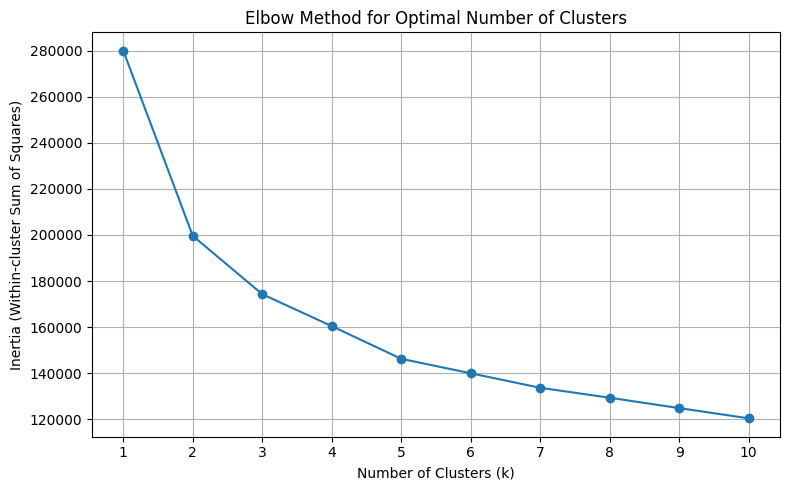

In [5]:
# Elbow Method to determine optimal number of clusters
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.xticks(cluster_range)
plt.grid(True)
plt.tight_layout()
plt.show()

From the elbow method, using K=4 or K=5 appears to be a good trade-off between model complexity and cluster compactness, as the rate of decrease in inertia begins to level off beyond this point.

<h2><b>Principal Component Analysis</b></h2>

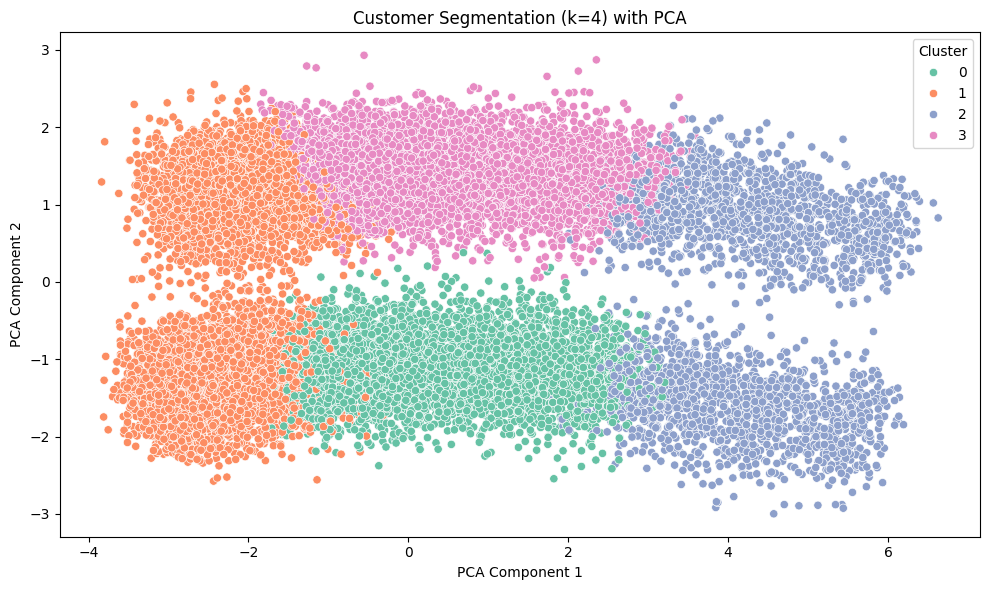

Cluster Profile (k=4):


,age,gender,income/month,account balance,loyalty score,education level,total_withdrawals,total_deposits,transaction_count,Facebook,Twitter,Email,Instagram,has_loan,PCA1,PCA2
Cluster,,,,,,,,,,,,,,,,
0,0.63,0.00,0.58,0.57,269.96,0.25,409.55,410.49,6.32,0.94,0.95,0.49,0.94,0.25,0.40,-1.12
1,0.19,0.48,0.31,0.29,335.23,0.24,494.63,498.24,1.82,0.98,0.98,0.51,0.98,0.13,-2.23,-0.12
2,0.92,0.50,0.76,0.75,476.63,0.25,120.08,122.56,8.60,0.36,0.37,0.49,0.38,0.31,4.17,-0.35
3,0.61,1.00,0.58,0.57,578.48,0.24,418.75,418.72,6.15,0.95,0.95,0.50,0.94,0.25,0.55,1.42


In [6]:
# Run KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels and PCA components
df_cluster['Cluster'] = clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

# Plot PCA clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Customer Segmentation (k=4) with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

cluster_profile = df_cluster.groupby('Cluster').mean(numeric_only=True).round(2)

# Display the cluster profile
print("Cluster Profile (k=4):")
cluster_profile

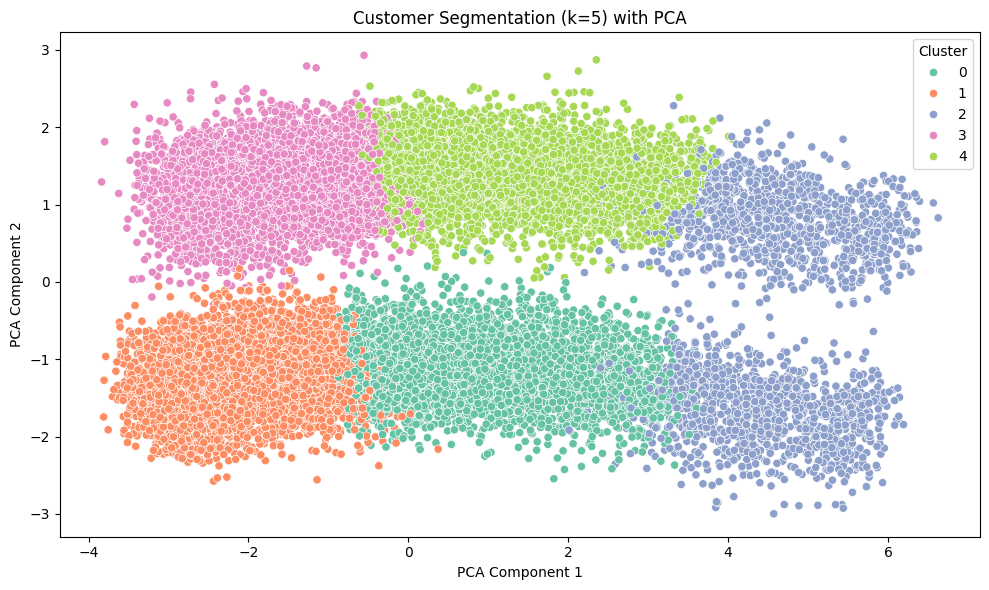

Cluster Profile (k=5):


,age,gender,income/month,account balance,loyalty score,education level,total_withdrawals,total_deposits,transaction_count,Facebook,Twitter,Email,Instagram,has_loan,PCA1,PCA2
Cluster,,,,,,,,,,,,,,,,
0,0.70,0.00,0.62,0.61,287.40,0.25,359.69,361.63,6.99,0.92,0.92,0.50,0.91,0.27,0.98,-1.12
1,0.25,0.00,0.35,0.33,203.59,0.24,503.81,507.02,2.43,0.98,0.98,0.49,0.98,0.14,-2.06,-1.26
2,0.94,0.49,0.77,0.76,477.65,0.25,99.69,99.51,8.59,0.28,0.28,0.48,0.30,0.31,4.49,-0.44
3,0.25,1.00,0.35,0.34,503.35,0.24,504.43,505.61,2.48,0.98,0.98,0.52,0.98,0.15,-1.76,1.24
4,0.71,1.00,0.63,0.62,590.79,0.24,353.72,356.35,7.07,0.92,0.91,0.50,0.91,0.28,1.32,1.38


In [8]:
kmeans = KMeans(n_clusters=5,random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels and PCA components
df_cluster['Cluster'] = clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

# Plot PCA clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Customer Segmentation (k=5) with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Cluster profiling: mean values of features for each cluster
cluster_profile = df_cluster.groupby('Cluster').mean(numeric_only=True).round(2)

# Display the cluster profile
print("Cluster Profile (k=5):")
cluster_profile

This PCA analysis shows that using K=4 or K=5 is suitable as the clusters are distinct enough for the derivation of business insights.

<h2><b>Choosing a model</b></h2>

It is important to note that on the bank marketing industry, most banks find 4 to 6 clusters strike the right balance between business insight and operational simplicity.

- Having too many clusters complicates the analysis, making it challenging to derive meaningful insights. It is also computationally more expensive.
- With too few clusters, distinct groups within the data may be merged, causing the model to overlook important patterns.

Below is the code used to decide which of the three different models (K=4,K=5,K=6) to use based on the silhouette score.

In [19]:
from sklearn.metrics import silhouette_score
# KMeans for k=4 and k=5 and k=6



kmeans_4 = KMeans(n_clusters=4,random_state=42)
labels_4 = kmeans_4.fit_predict(X_scaled)
silhouette_k4 = silhouette_score(X_scaled, labels_4)

kmeans_5 = KMeans(n_clusters=5,random_state=42)
labels_5 = kmeans_5.fit_predict(X_scaled)
silhouette_k5 = silhouette_score(X_scaled, labels_5)

kmeans_6 = KMeans(n_clusters=6,random_state=42)
labels_6 = kmeans_6.fit_predict(X_scaled)
silhouette_k6 = silhouette_score(X_scaled, labels_6)


print(f"Silhouette Score for k=4: {silhouette_k4:.4f}")
print(f"Silhouette Score for k=5: {silhouette_k5:.4f}")
print(f"Silhouette Score for k=6: {silhouette_k6:.4f}")

Silhouette Score for k=4: 0.1706
Silhouette Score for k=5: 0.1711
Silhouette Score for k=6: 0.1718


We note that since the silhouette scores only differ by a small amount, there is no strong statistical reason to prefer one over the other. Given that using K=4 uses less computational resources and is easier for interpretablility and business analysis purposes, we chose K=4.

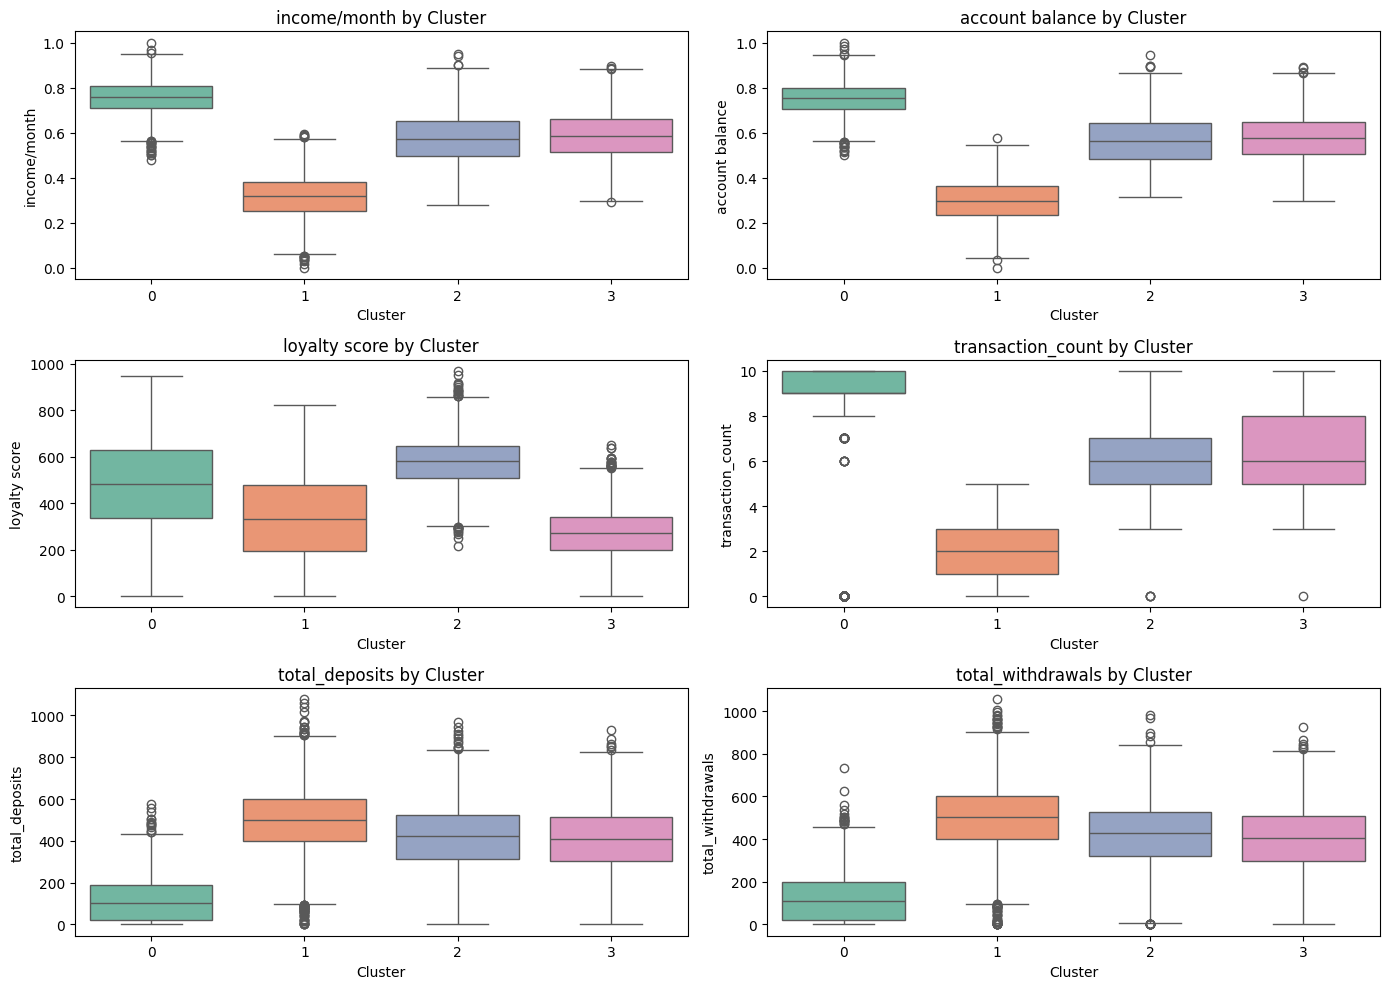

In [32]:
kmeans = KMeans(n_clusters=4,random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels and PCA components
df_cluster['Cluster'] = clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

# Profile clusters
cluster_profile = df_cluster.groupby('Cluster').mean(numeric_only=True).round(2)

# Plot visual breakdowns
key_features = ['income/month', 'account balance', 'loyalty score', 'transaction_count',"total_deposits","total_withdrawals"]


fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(data=df_cluster, x='Cluster', y=feature, hue='Cluster', ax=axs[i], palette='Set2', legend=False)
    axs[i].set_title(f'{feature} by Cluster')

plt.tight_layout()
plt.show()



<h2><b>Cluster analysis</b></h2>

- We define the amount of bank usage as the number of transactions
 (i.e. transaction count)
- We also define budget-consciousnessness based on the total withdrawal amount

We can segment these clusters as follows:
1. Cluster 0: frequent users, high income, medium loyalty, very budget conscious
2. Cluster 1: Occasional users, low income, low-medium loyalty, not budget conscious
3. Cluster 2: Semi-requent users, medium income, medium-high loyalty, not budget conscious
4. Cluster 3: Semi-frequent users, medium income, low loyalty, semi- budget conscious




- We note that Cluster 2 has the highest transaction account, account balance, income/month among all other clusters. This means that users in Cluster 2 are frequent users and potentially high value customers.

- However, cluster 2 also has the lower total deposits compared to the rest of the clusters.

- This might be because customers who transact frequently often make small-value purchases (e.g., daily coffee, snacks, transit), while those with fewer transactions may be making larger, occasional purchases (e.g., rent, investments, travel).


- In general among all clusters,
note that the income/month, account balance and transaction amount seem to be correlated.



<h2><b>Possible explanation of patterns</b></h2>

To examine why this might be the case, we plotted a correlation matrix below to determine relationships between these variables.

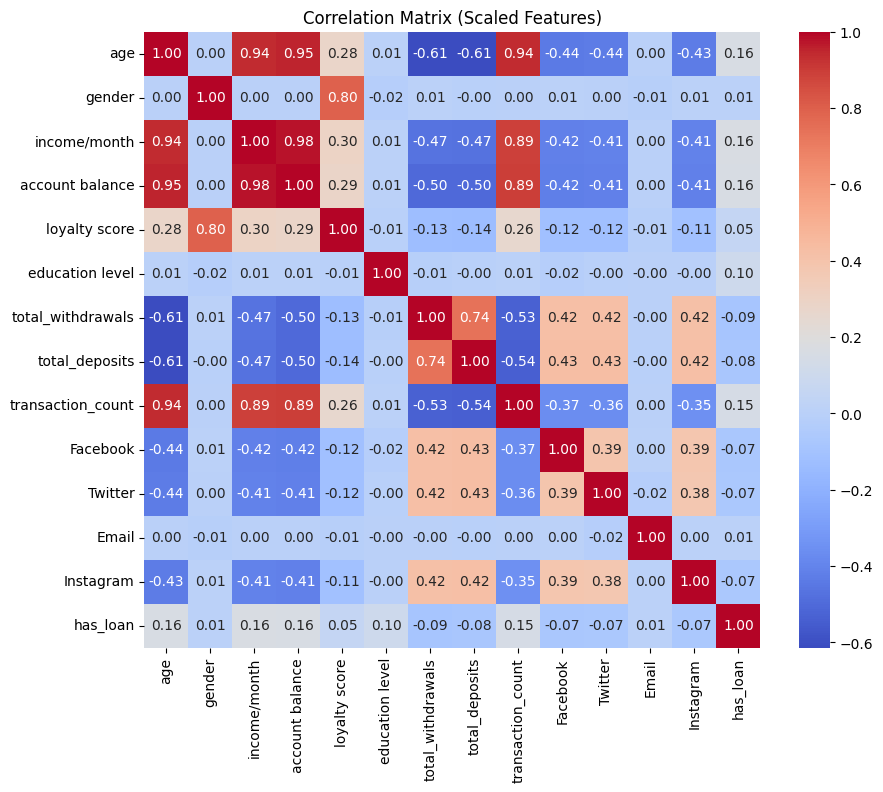

In [27]:
 # Convert to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=cluster_features)

# Compute and plot correlation matrix
corr_matrix = X_scaled_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Scaled Features)")
plt.show()


<h2><b>Findings</b></h2>

This correlation confirms our suspicion that income per month is strongly positively correlated with account balance and transaction count. This could be because higher-income individuals tend to maintain larger account balances and engage in more frequent financial activities, such as purchases, transfers, or investments. Their greater financial capacity often results in both higher liquidity (reflected in account balance) and increased transactional activity.


